## OpenAI to Z Challenge Checkpoint 1

Checkpoint 1 – Familiarize yourself with the challenge and data

Review all contents of our Starter Pack: OpenAI to Z Challenge
Spin up your workspace, prove you can load the core datasets, and call an OpenAI model.
1. Download one OpenTopography LiDAR tile or one Sentinel‑2 scene ID.
2. Run a single OpenAI o3/o4‑mini or GPT‑4.1 prompt on that data (e.g., “describe surface features
in plain English”).
3. Print model version and dataset ID.

### Setup: OpenAI API and Google Earth Engine API

In [15]:
import os
from kaggle_secrets import UserSecretsClient


def load_secret(name):
    """Loads secret from Colab/Kaggle."""

    if 'KAGGLE_KERNEL_RUN_TYPE' in os.environ:
        try:
            from kaggle_secrets import UserSecretsClient
            return UserSecretsClient().get_secret(name)
        except Exception:
            pass 
    else:
        try:
            from google.colab import userdata
            return userdata.get(name)
        except Exception: 
            pass

    return 'Secret not found'

The history saving thread hit an unexpected error (OperationalError('attempt to write a readonly database')).History will not be written to the database.


In [9]:
import os
import json

credentials_json = load_secret('google_ee_credentials')
os.makedirs('/root/.config/earthengine', exist_ok=True)

with open('/root/.config/earthengine/credentials', 'w') as f:
    f.write(credentials_json)

In [10]:
import ee
ee.Initialize(project="openaitozchallenge")

In [11]:
from openai import OpenAI

openai_key = load_secret('openai_key_2025')
client = OpenAI( api_key=openai_key )

In [9]:
import ee
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import io
import requests

def visualize_sentinel2(
    lat: float,
    lon: float,
    buffer_size: int = 1000,
    image_dataset_id: str = "COPERNICUS/S2_HARMONIZED",
    start_date: str = "2022-06-01",
    end_date: str = "2022-06-30",
    max_cloud_coverage: float = 10,
    rgb_bands: list = ['B4', 'B3', 'B2'],
    min_val: int = 0,
    max_val: int = 3000,
    dimensions: int = 1024
):
    """
    Visualize Sentinel-2 RGB image for a specific location and time period.
    
    Args:
        lat: Latitude coordinate of the point of interest
        lon: Longitude coordinate of the point of interest
        buffer_size: Buffer size in meters around the point
        image_dataset_id: Earth Engine dataset ID
        start_date: Start date for image filtering
        end_date: End date for image filtering
        max_cloud_coverage: Maximum allowed cloud coverage percentage
        rgb_bands: List of RGB bands to visualize
        min_val: Minimum value for visualization
        max_val: Maximum value for visualization
        dimensions: Maximum dimensions for the thumbnail
    
    Returns:
        A matplotlib figure showing the Sentinel-2 RGB image
    """    
    # Define area of interest
    aoi = ee.Geometry.Point([lon, lat])
    region = aoi.buffer(buffer_size).bounds()
    
    # Load and process image
    image = (ee.ImageCollection(image_dataset_id)
             .filterBounds(region)
             .filterDate(start_date, end_date)
             .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', max_cloud_coverage))
             .first()
             .clip(region))
    
    # Create RGB visualization
    rgb_image = image.select(rgb_bands).visualize(min=min_val, max=max_val)
    
    # Get thumbnail URL
    url = rgb_image.getThumbURL({
        'region': region,
        'dimensions': dimensions,
        'format': 'png'
    })
    
    # Fetch and display image
    response = requests.get(url)
    img = Image.open(io.BytesIO(response.content))
    
    # Create and display matplotlib figure
    fig, ax = plt.subplots(figsize=(6, 6))
    ax.imshow(img)
    ax.axis('off')
    title = f"Sentinel-2 RGB at ({lat:.4f}, {lon:.4f})"
    ax.set_title(title)
    
    return fig


### Download one OpenTopography LiDAR tile or one Sentinel‑2 scene ID. (Google Earth Engine)

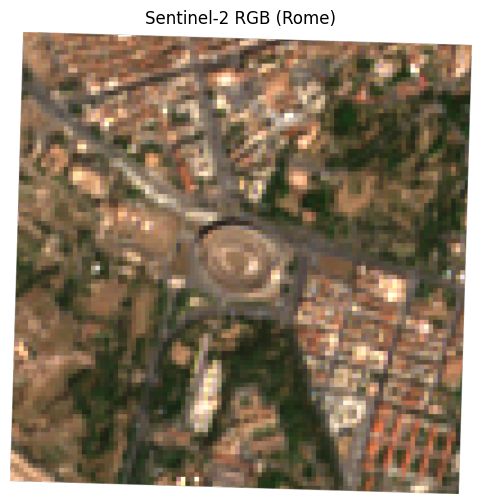

In [12]:
# Step 0: Setup and imports
import ee
import geemap
import folium
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import io

# Step 2: Define a small area of interest (AOI)
aoi = ee.Geometry.Point([12.4924, 41.8902])  # Rome, Italy (Colosseum area)
region = aoi.buffer(500).bounds()  # ~1km box
image_dataset_id = "COPERNICUS/S2_SR_HARMONIZED"


# Step 3: Load Sentinel-2 surface reflectance image collection
image = (ee.ImageCollection(image_dataset_id)
         .filterBounds(region)
         .filterDate("2022-06-01", "2022-06-30")
         .sort("CLOUDY_PIXEL_PERCENTAGE")
         .first()
         .clip(region))

# Step 4: Select bands for RGB and visualize
rgb_bands = ['B4', 'B3', 'B2']  # Red, Green, Blue

# Export a thumbnail image (low-res preview) as a BytesIO object
rgb_image = image.select(rgb_bands).visualize(min=0, max=3000)

# Download thumbnail (1024px max side length)
url = rgb_image.getThumbURL({
    'region': region,
    'dimensions': 1024,
    'format': 'png'
})

# Fetch and display
import requests
response = requests.get(url)
img = Image.open(io.BytesIO(response.content))

# Display using matplotlib
plt.figure(figsize=(6, 6))
plt.imshow(img)
plt.axis('off')
plt.title("Sentinel-2 RGB (Rome)")
plt.show()


In [13]:
img.save("sentinel2_rome.png")

### Run a single OpenAI o3/o4‑mini or GPT‑4.1 prompt on that data (e.g., “describe surface features in plain English”).

In [14]:
import base64

# Encode image
with open("sentinel2_rome.png", "rb") as f:
    encoded = base64.b64encode(f.read()).decode()

image_url = f"data:image/png;base64,{encoded}"
prompt = "Analyze this satellite image. What can you infer?"
model_id = "gpt-4.1-nano-2025-04-14"

# Send to GPT-4o-mini
response = client.responses.create(
    model= model_id,
    input=[
        {
            "role": "user",
            "content": [
                {"type": "input_text", "text": prompt},
                {"type": "input_image", "image_url": f"{image_url}"},
            ],
        }
    ],
)

print(response.output_text)
print("model id:",model_id)
print("dataset id:",image_dataset_id)


The satellite image appears to be quite pixelated and blurry, making detailed analysis challenging. However, some general observations can be made:

- There is a visible road network, including a roundabout, indicating an urban or suburban area.
- The surrounding areas seem to include patches of greenery or vegetation.
- The layout and density of the structures suggest a developed area with residential or mixed-use buildings.
- The central circular feature could be a park, a roundabout, or a significant landmark or structure.

Overall, this seems to be a part of a town or city with organized infrastructure, possibly with parks or green spaces interspersed within the urban environment. For a more precise analysis, a higher resolution image would be necessary.
model id: gpt-4.1-nano-2025-04-14
dataset id: COPERNICUS/S2_SR_HARMONIZED


## OpenAI to Z Challenge Checkpoint 2

Checkpoint 2 – An early explorer

Show us you can mine and gather insights from multiple data types. Submit code that:
1. Loads two independent public sources (e.g., GEDI + TerraBrasilis polygons)
2. Produces at least five candidate “anomaly” footprints (bbox WKT or lat/lon center + radius)
3. Logs all dataset IDs and OpenAI prompts. Verify: Automated script re‑runs → same five
footprints ±50 m.
4. Show us how you can use this new data in future discovery - re-prompt the model with this
leverage.

### Loads two independent public sources (e.g., GEDI + TerraBrasilis polygons)

yay!


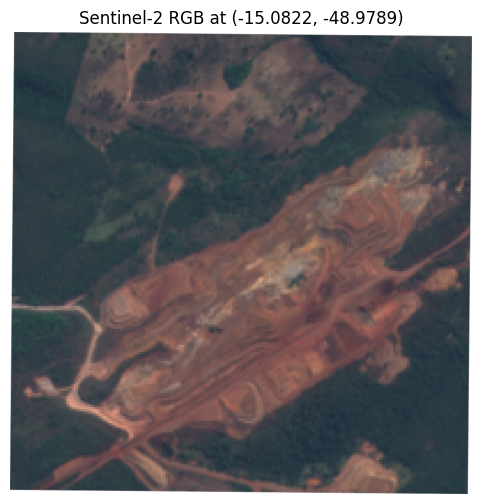

In [22]:
import pandas as pd

file_path = '/kaggle/input/historical-and-archeological-sites-in-brazil/translated_sites.csv'
df = pd.read_csv(file_path)

visualize_sentinel2(
    lat=df['latitude'][0],
    lon=df['longitude'][0],
    max_cloud_coverage=20
)
print("yay!")

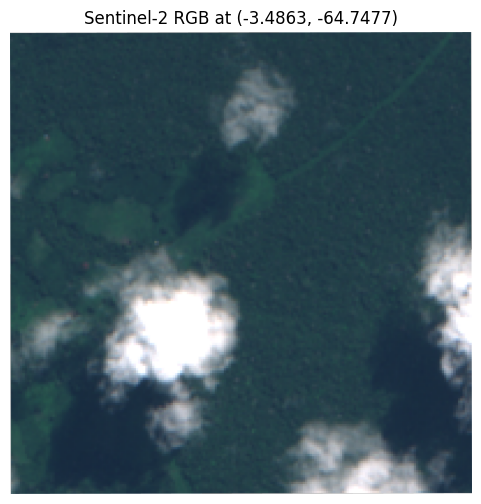

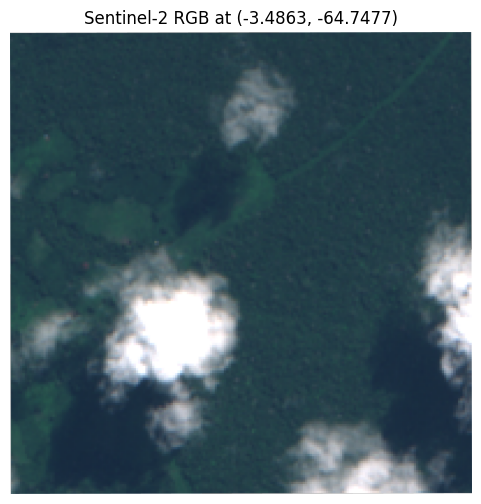

In [14]:
# Example usage
visualize_sentinel2(
    lat=-3.4863,
    lon=-64.7477,
    max_cloud_coverage=20
)


### Produces at least five candidate “anomaly” footprints (bbox WKT or lat/lon center + radius)